In [276]:
import pandas as pd
import numpy as np

all_df = pd.read_excel('TrainDataset2024.xls', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.shape

(400, 120)

### Data imputation

before impute:
Gene
0      193
1      119
999     88
Name: count, dtype: int64
after impute:
Gene
0    281
1    119
Name: count, dtype: int64


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


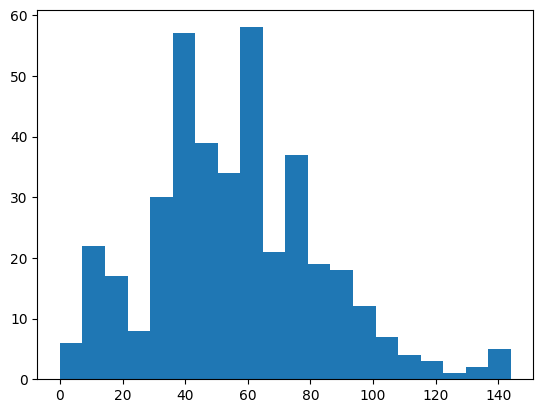

(400, 120)

In [277]:
import pickle
import joblib
from sklearn.impute import SimpleImputer

# load gene clf feature names
import json
keep_feat_names = []
with open('gene_clf_selected_features.json', 'rb') as f:
  keep_feat_names = json.load(f)
  
# replace missing gene with classification result
# see train_gene_classifier.ipynb for more details
with open('log_reg_gene_classifier.pkl', 'rb') as f:
  log_res_clf = pickle.load(f)
  
  # rebuild prediction df
  gene_impute_df = all_df.copy()

  temp_X = gene_impute_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)
  y = gene_impute_df['Gene']

  print("before impute:") 
  print(gene_impute_df['Gene'].value_counts())

  keep_df = temp_X[keep_feat_names]
  replace_index = keep_df[keep_df['Gene'] == 999].index

  # get prediction on missing gene
  target = gene_impute_df.loc[replace_index, keep_feat_names]
  target.drop('Gene', axis=1, inplace=True)

  pred = log_res_clf.predict(target)
  gene_impute_df.loc[replace_index, 'Gene'] = pred

  print("after impute:") 
  print(gene_impute_df['Gene'].value_counts())

  # assign back to all_df
  all_df['Gene'] = gene_impute_df['Gene']

# Replace missing values with median of the column
imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

#plot distribution of rgr_y
import matplotlib.pyplot as plt
plt.hist(rgr_y, bins=20)
plt.show()


all_df.shape

### Outlier Removal

In [278]:
from outlier_removal import removeOutliers
removeOutliers(all_df)
# keep pCR outcome as training set
X = all_df.drop(['RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1)

### Dimentionality Reduction - Manifold Learning

(400, 107)


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(400, 2)


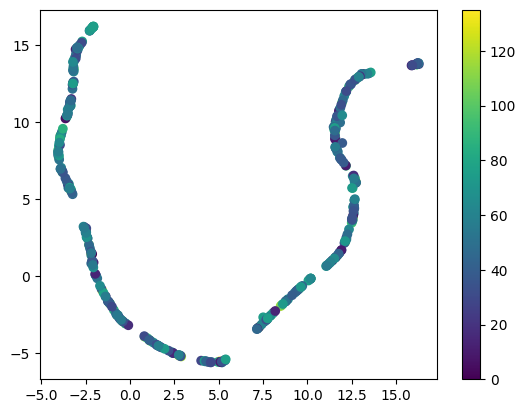

(400, 13)

In [279]:
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler

umap = UMAP(n_components=2, random_state=42)
print(X.iloc[:,11:].shape)
X_umap_mri = umap.fit_transform(X.iloc[:, 11:])
print(X_umap_mri.shape)

joblib.dump(umap, "umap_model.pkl")

# plot UMAP
import matplotlib.pyplot as plt
plt.scatter(X_umap_mri[:, 0], X_umap_mri[:, 1], c=rgr_y, cmap='viridis')
plt.colorbar()
plt.show()


scaler = StandardScaler()
Xs_non_mri = scaler.fit_transform(X.iloc[:, :11])

Xs = np.c_[Xs_non_mri, X_umap_mri]
Xs.shape

### Train Test Split

In [280]:
from sklearn.model_selection import train_test_split

# Compute sample weights
X_train, X_test, y_train, y_test = train_test_split(Xs, rgr_y, test_size=0.2, random_state=42)

### SVR Hyper-parameter Tuning

In [281]:
# svr 
from random import sample
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Get sample weights to follow the distribution of the target

grid_search = GridSearchCV(SVR(), param_grid, n_jobs=-1, cv=5, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=2)

### Random Forest Hyperparameter Tuning

In [282]:
#import randomforest
from sklearn.ensemble import RandomForestRegressor

# change depth
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 80, 90, 200],
    'max_features': ['auto', 'sqrt', 'log2', 20, 40],

}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=-1, cv=5, verbose=2, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
300 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
226 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\sklearn\base.py", line 666, in _validate_pa

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50, 60, 80, 90,
                                       200],
                         'max_features': ['auto', 'sqrt', 'log2', 20, 40],
                         'n_estimators': [10, 50, 100, 200, 300, 400]},
             scoring='neg_mean_absolute_error', verbose=2)

### Validation

[67.18860596 60.49444032 55.40453409 65.16486262 54.3466171  49.29067325
 54.19002877 51.76808311 69.99037542 52.89646122 64.03734045 51.32481094
 59.96457008 56.63965013 54.38979184 52.14963103 65.17344642 62.50493452
 51.91571886 54.54664106]
MAE:  21.659437921491044
R2:  -0.03743919769228188


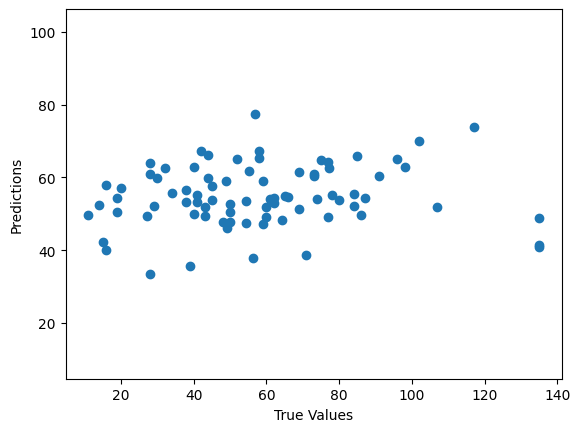

In [283]:
from sklearn.metrics import mean_absolute_error, r2_score

best = grid_search.best_estimator_

y_pred = best.predict(X_test)
print(y_pred[40:60])

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

# plot train vs test
# plt.scatter(y_train, best.predict(X_train))
# plt.xlabel("True Values")
# plt.ylabel("Predicted Values")
# plt.title("Training Data Predictions")
# plt.axis('equal')
# plt.show()



# plot test vs predicted
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()


MAE:  22.05904776923177


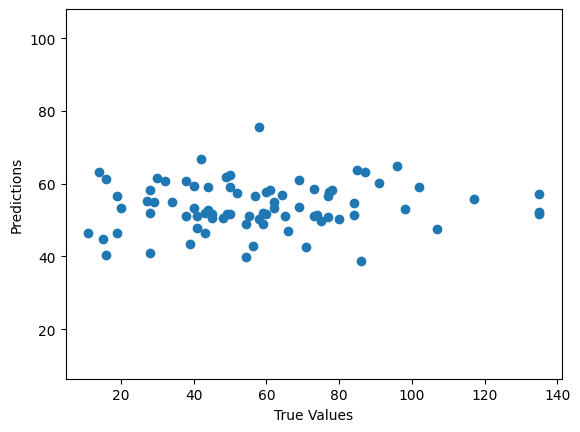

In [284]:
from sklearn.linear_model import LinearRegression
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

print("MAE: ", mean_absolute_error(y_test, y_pred_baseline))

#plot 
plt.scatter(y_test, y_pred_baseline)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()


### Random Forest for Regression + Hyper Param Tuning

In [285]:
# save model
with open('rfs_regression_model.pkl', 'wb') as f:
  pickle.dump(best, f)